## Лабораторная
## Исследование t-SNE + kNN

In [14]:
import numpy as np
import pandas
from matplotlib import pyplot
from sklearn.decomposition import PCA
import scipy as sp
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
from sklearn.metrics import accuracy_score
import random
#%pylab inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Загрузим обучающую выборку:

In [2]:
hard_train = np.loadtxt('hard_train.txt')
hard_train_labels = np.loadtxt('hard_train_labels.txt')

Функция, которая blocks_number раз разбивает выборку на части размеров $10^4, 10^3$ случайно перемешивая выборку и извлекая непересекающиеся блоки последовательных элементов указанных размеров: (как в pca + knn)

In [3]:
samples = list(zip(hard_train, hard_train_labels))

def getShuffledSamples(blocks_number):
    shuffledSamples = [() for i in range(blocks_number)]
    
    for i in range(blocks_number):
        random.shuffle(samples)
        sample_begin_index = 0
        
        X_shuffled = list(map(lambda x: x[0], samples))
        y_shuffled = list(map(lambda x: x[1], samples))
        
        X_train = (X_shuffled)[: 10000]
        y_train = (y_shuffled)[: 10000]
        
        X_test = (X_shuffled)[10000 : 11000]
        y_test = (y_shuffled)[10000 : 11000]
        
        shuffledSamples[i] = [X_train, y_train, X_test, y_test]
            
    return shuffledSamples

Извлечем одну выборку X_train, y_train, X_test, y_test:

In [4]:
shuffledSamples = getShuffledSamples(1)
X_train = shuffledSamples[0][0]
y_train = shuffledSamples[0][1]

#### Применим t-SNE для двух главных компонент в X_train:

In [9]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_train)

Визуализируем выборку, взяв в качестве цвета точки ее метку класса:

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


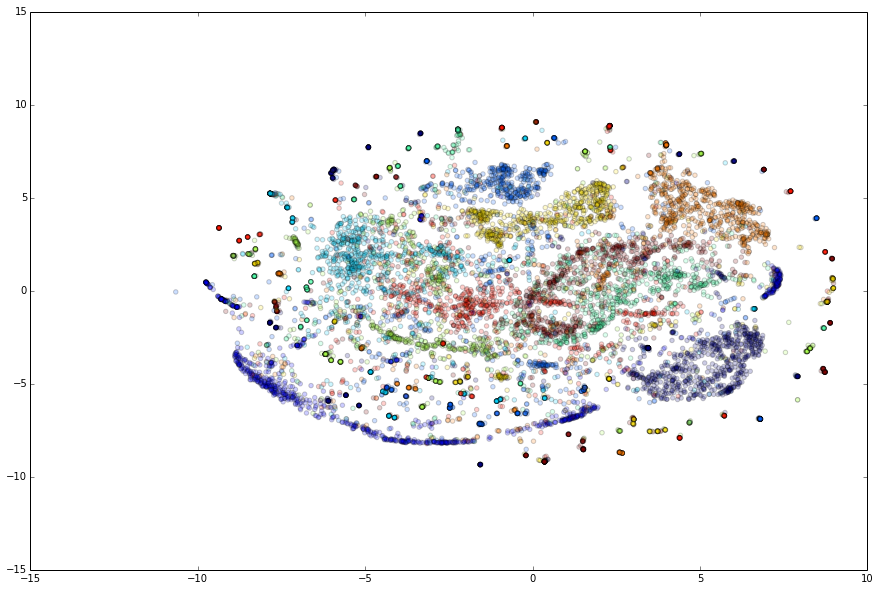

In [17]:
pyplot.figure(figsize=(15, 10))
pyplot.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, alpha=0.2)
pyplot.show()

### Применение t-SNE и kNN для $d \in \{1, \dots, 5\}, k \in \{1, \dots, 20\}$:

In [4]:
def tsneKNN(X_train, y_train, X_test, y_test, d):
    accuracies = [0 for i in range(20)]
    times = [0 for i in range(20)]
    
    start_tsne = datetime.now()

    tsne = TSNE(n_components=d)
    X = np.vstack((X_train, X_test))
    X_tsne = tsne.fit_transform(X)

    end_tsne = datetime.now()
    time_tsne = (end_tsne - start_tsne).total_seconds()

    X_train_tsne = X_tsne[:10000]
    X_test_tsne = X_tsne[10000:]

    for k in range(1, 21):
        start_knn = datetime.now()

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_tsne, y_train)

        y_predicted = knn.predict(X_test_tsne)

        end_knn = datetime.now()
        time_knn = (end_knn - start_knn).total_seconds()

        d_k_accuracy = accuracy_score(y_test, y_predicted)

        accuracies[k - 1] = d_k_accuracy
        times[k - 1] = time_tsne + time_knn
            
    return accuracies, times

Сгенерируем 5 случайных выборок X_train, y_train, X_test, y_test:

In [5]:
shuffledSamples = getShuffledSamples(5) 

Применим теперь к каждой сгенерированной выборке tsneKNN:

In [4]:
got_accuracies = [[[] for i in range(5)] for j in range(5)]
got_times = [[[] for i in range(5)] for j in range(5)]

Так как работает t-SNE очень долго, будем запускать tsneKNN отдельно для каждого d. и сохранять полученные результаты в файл accuraces_di.csv, где i -- значение d:

In [7]:
def executeWithD(d):
    for i in range(5):
        X_train = shuffledSamples[i][0]
        y_train = shuffledSamples[i][1]
        X_test = shuffledSamples[i][2]
        y_test = shuffledSamples[i][3]

        got_accuracies[d - 1][i], got_times[d - 1][i] = tsneKNN(X_train, y_train, X_test, y_test, d)

Тут по очереди будем запускать для d от 1 до 5 и сохранять в файлик:

In [ ]:
executeWithD(5)

In [ ]:
pandas.DataFrame(got_accuracies[4]).to_csv('accuraces_d5.csv')
pandas.DataFrame(got_times[4]).to_csv('times_d5.csv')

Считаем данные из файлов accuraces_di.csv обратно в got_accuracies и got_times:

In [5]:
for i in range(1, 6):
    got_accuracies[i - 1] = pandas.read_csv('accuraces_d%s.csv' % i)
    got_times[i - 1] = pandas.read_csv('times_d%s.csv' % i)

Для каждого d, k, усредним значение accuracy на пяти выборках и запишем в mean_accuracies$[d][k]$:

In [6]:
mean_accuracies = [[i for i in range(20)] for j in range(5)]
mean_times = [[i for i in range(20)] for j in range(5)]

for d in range(5):
    for k in range(20):
        d_k_accuracies = [got_accuracies[d][[k + 1]].loc[x] for x in range(5)]
        d_k_times = [got_times[d][[k + 1]].loc[x] for x in range(5)]

        mean_accuracies[d][k] = np.mean(d_k_accuracies)
        mean_times[d][k] = np.mean(d_k_times)

### Найдем d и k, при которых accuracy максимально:

In [8]:
max_d = 0
max_k = 0
max_accuracy = 0

for d in range(5):
    for k in range(20):
        if mean_accuracies[d][k] > max_accuracy:
            max_d = d + 1
            max_k = k + 1
            max_accuracy = mean_accuracies[d][k]
            
print('max accuracy:', max_accuracy)
print('corresponding d:', max_d)
print('corresponding k:', max_k)

max accuracy: 0.8766
corresponding d: 3
corresponding k: 4


Посмотрим, для каких k и d accuracy отличается от max_accuracy ненамного:

In [9]:
eps = 0.01

for d in range(5):
    for k in range(20):
        if abs(mean_accuracies[d][k] - max_accuracy) < eps:
            print('accuracy:', mean_accuracies[d][k])
            print('corresponding d:', d + 1)
            print('corresponding k:', k + 1)

accuracy: 0.8754
corresponding d: 3
corresponding k: 3
accuracy: 0.8766
corresponding d: 3
corresponding k: 4
accuracy: 0.8754
corresponding d: 3
corresponding k: 5
accuracy: 0.8736
corresponding d: 3
corresponding k: 6
accuracy: 0.8746
corresponding d: 3
corresponding k: 7
accuracy: 0.8714
corresponding d: 3
corresponding k: 8
accuracy: 0.869
corresponding d: 3
corresponding k: 9
accuracy: 0.8688
corresponding d: 3
corresponding k: 10
accuracy: 0.868
corresponding d: 3
corresponding k: 11
accuracy: 0.8674
corresponding d: 3
corresponding k: 12


Как видно, близко к max_accuracy только для d=3. 

Возможно, это связано с тем, что при проецировании на пространство большей размерности есть множество вариантов спроецировать так, чтоб сохранить относительные расстояния. И получается некая неопределенность.

### Визуализируем матрицы качества и времени работы в зависимости от d и k:

#### Качество (accuracy):

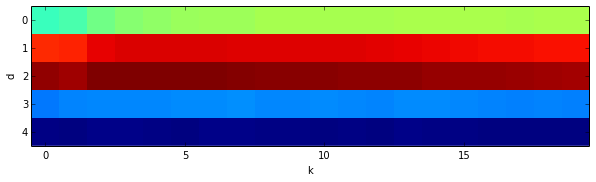

In [12]:
pyplot.figure(figsize=(10, 10))

pyplot.xlabel('k')
pyplot.ylabel('d')
pyplot.imshow(mean_accuracies, interpolation='none')

pyplot.show()

#### Время (time):

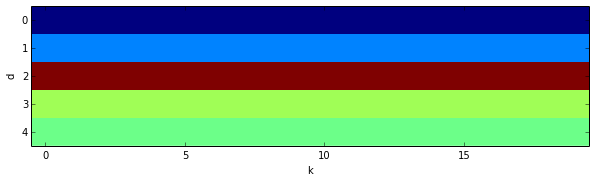

In [13]:
pyplot.figure(figsize=(10, 10))

pyplot.xlabel('k')
pyplot.ylabel('d')
pyplot.imshow(mean_times, interpolation='none')

pyplot.show()